# Ramsey King
# DSC 550 - Data Mining
# October 10, 2021
# Term Project Milestone 1

In [4]:
# Retreive talks from topics page using beautifulsoup

from bs4 import BeautifulSoup as bs
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [25]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = ['life/', 'jesus-christ/', 'faith/', 'learning/', 'service/']

links = []
new_links = []
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



In [108]:
# Retrieves talk text from each of the urls using beautiful soup.
talk_text = []
title_text = []
topics = []
dates = []
speakers = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
df.to_csv('talks.csv')

In [152]:
# get character lengths of each talk (may need to eliminate those less than 250 chars)
df['char_lengths'] = pd.Series([len(x) for x in df.talks])
# df.head(10)

In [153]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

In [206]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')

# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)
# remove quotations ("") from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
df['month_number'] = df['month'].apply(month_to_int)

df.shape


(456, 11)

In [207]:
# Take a peek at the data
df.head(7)

,titles,speaker,date,talks,topics,char_lengths,word_count,topic_singular,month,year,month_number
0,A Proper Orientation on the Threshold of Life,mark e petersen,"January 1, 1962","The things of the world, or of the flesh, must...","life,revelation",236,43,life,January,1962,1
1,Building Your Future,earl m woolley,"October 3, 2000",It is frightening to be asked to speak to you ...,"learning,life",23750,4084,life,October,2000,10
2,Would You Sell,carlos e asay,"March 13, 1984",It is reported that the Prophet Joseph Smith s...,"life,opportunity",25098,4579,life,March,1984,3
3,One Step Enough,john s tanner,"June 30, 1992",In a Facetious Little Essay entitled “On Trans...,faith,26039,4710,faith,June,1992,6
4,The Story of My Life,thomas l martin,"October 30, 1951",Thomas L. Martin humorously describes the main...,"adversity,attitude,blessings,commitment,decisi...",239,41,faith,October,1951,10
5,The Power of Your Words,craig manning,"January 31, 2017",I would like to explain the sequence of how I ...,"faith,fear,podcast: recent speeches",17937,3326,faith,January,2017,1
6,Prepare for Useful Service,antoine r ivins,"December 3, 1963",Antoine R. Ivins gives students spiritual and ...,"preparation,service",216,34,service,December,1963,12


In [208]:
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
       char_lengths   word_count         year  month_number
count    456.000000   456.000000   456.000000    456.000000
mean   17916.844298  3259.418860  1997.914474      6.348684
std    11164.464968  2038.400655    18.178702      3.269425
min       84.000000    13.000000  1949.000000      1.000000
25%     8087.500000  1446.250000  1987.000000      4.000000
50%    20933.500000  3809.000000  2003.000000      6.000000
75%    25403.250000  4675.250000  2012.000000      9.000000
max    44865.000000  8284.000000  2021.000000     12.000000
Summarized Data
                   titles            speaker            date  \
count                 456                456             456   
unique                453                304             424   
top     Go Forth to Serve  cecil o samuelson  April 30, 2004   
freq                    3                 13               6   

                                                    talks topics  \
count                                    

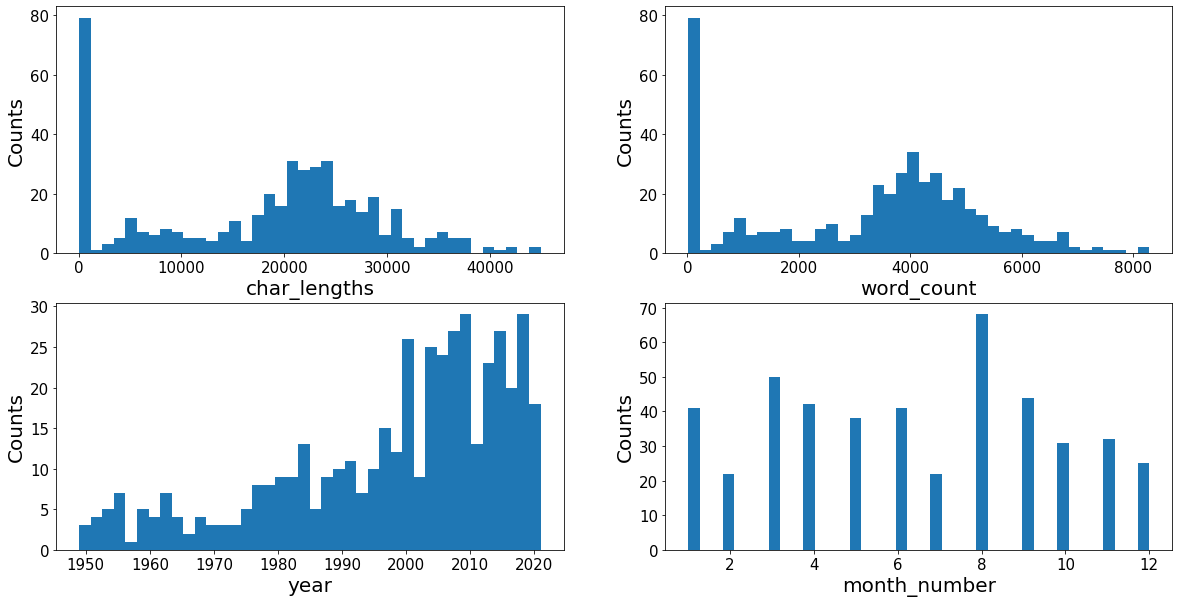

In [210]:
import matplotlib.pyplot as plt

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# Specify the features of interest
num_features = ['char_lengths', 'word_count', 'year', 'month_number']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(df[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
plt.show()

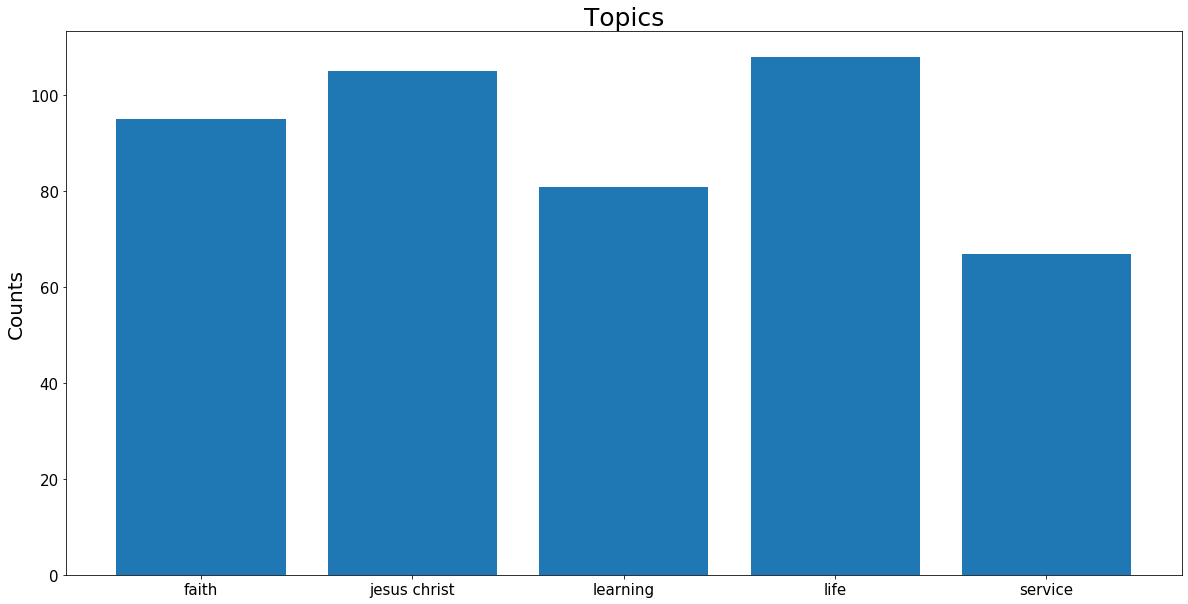

In [213]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.bar(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


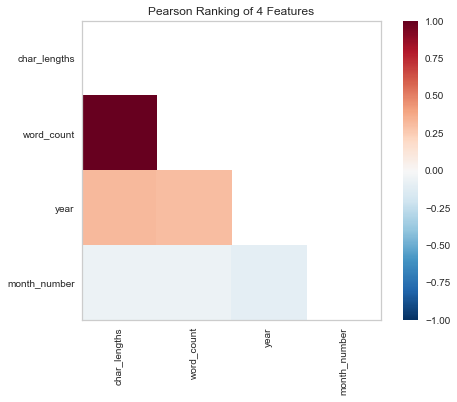

In [214]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

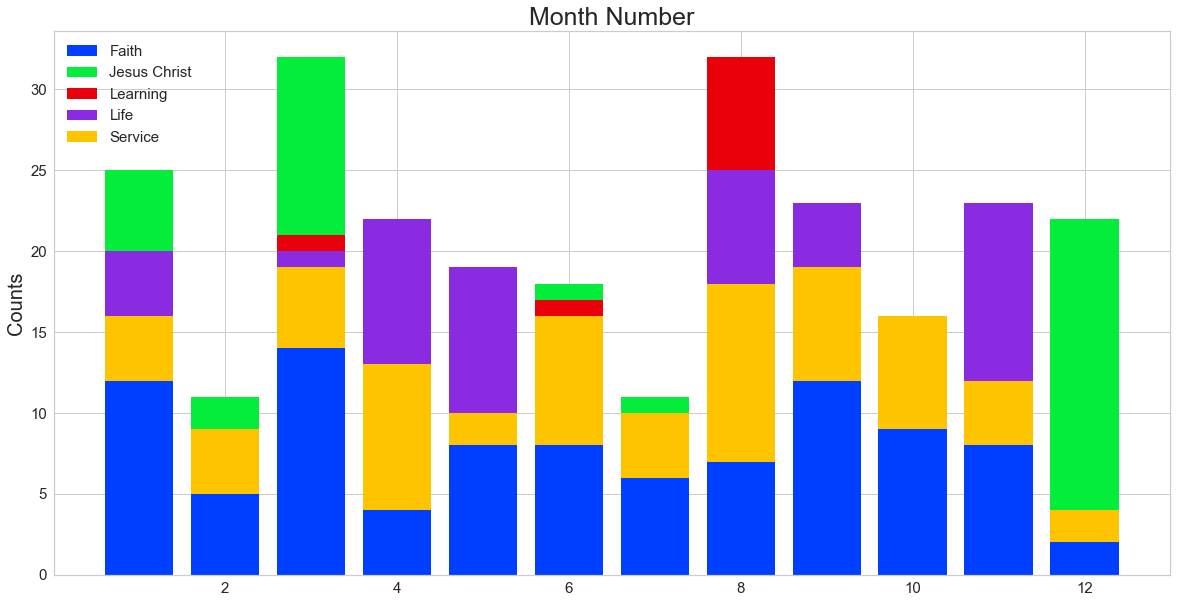

In [221]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
month_number_faith = df[df['topic_singular']=='faith']['month_number'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_number'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_number'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_number'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_number'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)
# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values)
axes.set_title('Month Number', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

# # make the data read to feed into the visualizer
# Pclass_survived = df.replace({'Survived': {1: 'Survived', 0: 'Not-survived'}}).replace({'Pclass': {1: '1st', 2: '2nd', 3: '3rd'}})[df['Survived']==1]['Pclass'].value_counts()
# Pclass_not_survived = df.replace({'Survived': {1: 'Survived', 0: 'Not-survived'}}).replace({'Pclass': {1: '1st', 2: '2nd', 3: '3rd'}})[df['Survived']==0]['Pclass'].value_counts()
# Pclass_not_survived = Pclass_not_survived.reindex(index = Pclass_survived.index)
# # make the bar plot
# p3 = axes[0, 1].bar(Pclass_survived.index, Pclass_survived.values)
# p4 = axes[0, 1].bar(Pclass_not_survived.index, Pclass_not_survived.values, bottom=Pclass_survived.values)
# axes[0, 1].set_title('Pclass', fontsize=25)
# axes[0, 1].set_ylabel('Counts', fontsize=20)
# axes[0, 1].tick_params(axis='both', labelsize=15)
# axes[0, 1].legend((p3[0], p4[0]), ('Survived', 'Not-survived'), fontsize = 15)

# # make the data read to feed into the visualizer
# Embarked_survived = df.replace({'Survived': {1: 'Survived', 0: 'Not-survived'}})[df['Survived']==1]['Embarked'].value_counts()
# Embarked_not_survived = df.replace({'Survived': {1: 'Survived', 0: 'Not-survived'}})[df['Survived']==0]['Embarked'].value_counts()
# Embarked_not_survived = Embarked_not_survived.reindex(index = Embarked_survived.index)
# # make the bar plot
# p5 = axes[1, 0].bar(Embarked_survived.index, Embarked_survived.values)
# p6 = axes[1, 0].bar(Embarked_not_survived.index, Embarked_not_survived.values, bottom=Embarked_survived.values)
# axes[1, 0].set_title('Embarked', fontsize=25)
# axes[1, 0].set_ylabel('Counts', fontsize=20)
# axes[1, 0].tick_params(axis='both', labelsize=15)
# axes[1, 0].legend((p5[0], p6[0]), ('Survived', 'Not-survived'), fontsize = 15)
plt.show()
